In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
import igraph as ig
from timeit import default_timer as timer

# scipy
import random
import scipy.stats as scistats
import scipy.linalg as slin
import scipy.optimize as sopt
from scipy.special import expit as sigmoid

In [2]:
def k_ols_W(Psi, P):
    # translate X
    psi = P @ Psi @ P.T
    W_hat = np.zeros((p, p))

    # get parameters
    for i in range(1, p):
        psi_F = psi[np.array(range(i))[:, None], np.array(range(i))[None, :]]   
        W_hat[np.array(range(i))[:, None], i] = np.linalg.inv(psi_F) @ psi[np.array(range(i))[:, None], i]

    return P.T @ W_hat @ P

def ols_W(X, P):
    # translate X
    x = X @ P.T

    W_hat = np.array(np.zeros(p)).T

    # get parameters
    for i in range(p):
        if i == 0:
            W_hat = np.vstack((W_hat, np.zeros(p)))
        else:
            est = sm.OLS(x[:, i], x[:, :i]).fit()   
            W_hat = np.vstack((W_hat, np.append(est.params, np.zeros(p - i)).T))

    return P.T @ W_hat[1:].T @ P

def ols_W_full(X):
    # translate X
    x = X

    W_hat = np.array(np.zeros(p)).T

    # get parameters
    for i in range(p):
        est = sm.OLS(x[:, i], np.delete(x, i, axis = 1)).fit()  
        W_hat = np.vstack((W_hat, np.append(est.params[:i], np.append(0, est.params[i:])).T)) 
        # W_hat = np.vstack((W_hat, np.append(est.params, np.zeros(1)).T))

    return W_hat[1:].T

In [3]:
def generate_U(p, num_edges, low = 0.5, high = 2.0, tril = False):
    edges = np.array([0.0] * (int(p * (p + 1) / 2) - num_edges - p * tril) + [1.0] * num_edges)
    
    edges[edges > 0] = (2 * np.random.randint(0, 2, size=(num_edges)) - 1) * np.random.uniform(low, high, num_edges)
    np.random.shuffle(edges)
    
    U = np.zeros((p, p))
    
    U[np.tril_indices(p, - tril)] = edges
    
    return U

In [4]:
def notears_linear(X, lambda1, loss_type, max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.3, verbose = True):
    """Solve min_W L(W; X) + lambda1 ‖W‖_1 s.t. h(W) = 0 using augmented Lagrangian.

    Args:
        X (np.ndarray): [n, d] sample matrix
        lambda1 (float): l1 penalty parameter
        loss_type (str): l2, logistic, poisson
        max_iter (int): max num of dual ascent steps
        h_tol (float): exit if |h(w_est)| <= htol
        rho_max (float): exit if rho >= rho_max
        w_threshold (float): drop edge if |weight| < threshold

    Returns:
        W_est (np.ndarray): [d, d] estimated DAG
    """
    def _loss(W):
        """Evaluate value and gradient of loss."""
        M = X @ W

        if loss_type == 'l2-var':
            R = X[1:] - M[:-1]
            loss = 0.5 / X[1:].shape[0] * (R ** 2).sum()
            G_loss = - 1.0 / X[1:].shape[0] * X[:-1].T @ R
        elif loss_type == 'l2':
            R = X - M
            loss = 0.5 / X.shape[0] * (R ** 2).sum()
            G_loss = - 1.0 / X.shape[0] * X.T @ R
        elif loss_type == 'logistic':
            loss = 1.0 / X.shape[0] * (np.logaddexp(0, M) - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (sigmoid(M) - X)
        elif loss_type == 'poisson':
            S = np.exp(M)
            loss = 1.0 / X.shape[0] * (S - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (S - X)
        else:
            raise ValueError('unknown loss type')
        return loss, G_loss

    def _h(W):
        """Evaluate value and gradient of acyclicity constraint."""
        W2 = W.copy()

        if loss_type == "l2-var": 
            np.fill_diagonal(W2, np.zeros(np.shape(W)[0]))
		
        E = slin.expm(W2 * W2)  # (Zheng et al. 2018)
        h = np.trace(E) - d
        #     # A different formulation, slightly faster at the cost of numerical stability
        #     M = np.eye(d) + W * W / d  # (Yu et al. 2019)
        #     E = np.linalg.matrix_power(M, d - 1)
        #     h = (E.T * M).sum() - d
        G_h = E.T * W2 * 2
        return h, G_h

    def _adj(w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        return (w[:d * d] - w[d * d:]).reshape([d, d])

    def _func(w):
        """Evaluate value and gradient of augmented Lagrangian for doubled variables ([2 d^2] array)."""
        W = _adj(w)
        loss, G_loss = _loss(W)
        h, G_h = _h(W)
        obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
        G_smooth = G_loss + (rho * h + alpha) * G_h
        g_obj = np.concatenate((G_smooth + lambda1, - G_smooth + lambda1), axis=None)
        return obj, g_obj

    n, d = X.shape
    w_est, rho, alpha, h = np.zeros(2 * d * d), 1.0, 0.0, np.inf  # double w_est into (w_pos, w_neg)
    bnds = [(0, None) for _ in range(2) for i in range(d) for j in range(d)]
    if loss_type == 'l2':
        X = X - np.mean(X, axis=0, keepdims=True)
    for q in range(max_iter):
        print(q, end = "")
        w_new, h_new = None, None
        while rho < rho_max:
            sol = sopt.minimize(_func, w_est, method='L-BFGS-B', jac=True, bounds=bnds)
            w_new = sol.x
            h_new, _ = _h(_adj(w_new))
            if h_new > 0.25 * h:
                rho *= 10
            else:
                break
        w_est, h = w_new, h_new
        alpha += rho * h * 10
        if h <= h_tol or rho >= rho_max:
            break
			
    W_est = _adj(w_est)
    W_est[np.abs(W_est) < w_threshold] = 0
	
	# h, rho, gradient of h
    if verbose:
        print(f"h: {h}.\nrho: {rho}.")
        print(f"loss: {_func(w_est)}.")	

    return W_est, h

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)


def is_dag(W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.simplify().is_dag()


def simulate_dag(d, s0, graph_type):
    """Simulate random DAG with some expected number of edges.

    Args:
        d (int): num of nodes
        s0 (int): expected num of edges
        graph_type (str): ER, SF, BP

    Returns:
        B (np.ndarray): [d, d] binary adj matrix of DAG
    """
    def _random_permutation(M):
        # np.random.permutation permutes first axis only
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    def _random_acyclic_orientation(B_und):
        return np.tril(_random_permutation(B_und), k=-1)

    def _graph_to_adjmat(G):
        return np.array(G.get_adjacency().data)

    if graph_type == 'ER':
        # Erdos-Renyi
        G_und = ig.Graph.Erdos_Renyi(n=d, m=s0)
        B_und = _graph_to_adjmat(G_und)
        B = _random_acyclic_orientation(B_und)
    elif graph_type == 'SF':
        # Scale-free, Barabasi-Albert
        G = ig.Graph.Barabasi(n=d, m=int(round(s0 / d)), directed=True)
        B = _graph_to_adjmat(G)
    elif graph_type == 'BP':
        # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
        top = int(0.2 * d)
        G = ig.Graph.Random_Bipartite(top, d - top, m=s0, directed=True, neimode=ig.OUT)
        B = _graph_to_adjmat(G)
    else:
        raise ValueError('unknown graph type')
    B_perm = _random_permutation(B)
    assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
    return B_perm


def simulate_parameter(B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        w_ranges (tuple): disjoint weight ranges

    Returns:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
    """
    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    return W


def simulate_linear_sem(W, n, sem_type, noise_scale=None):
    """Simulate samples from linear SEM with specified type of noise.

    For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

    Args:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
        n (int): num of samples, n=inf mimics population risk
        sem_type (str): gauss, exp, gumbel, uniform, logistic, poisson
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix, [d, d] if n=inf
    """
    def _simulate_single_equation(X, w, scale):
        """X: [n, num of parents], w: [num of parents], x: [n]"""
        if sem_type == 'gauss':
            z = np.random.normal(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'exp':
            z = np.random.exponential(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'gumbel':
            z = np.random.gumbel(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'uniform':
            z = np.random.uniform(low=-scale, high=scale, size=n)
            x = X @ w + z
        elif sem_type == 'logistic':
            x = np.random.binomial(1, sigmoid(X @ w)) * 1.0
        elif sem_type == 'poisson':
            x = np.random.poisson(np.exp(X @ w)) * 1.0
        else:
            raise ValueError('unknown sem type')
        return x

    d = W.shape[0]
    if noise_scale is None:
        scale_vec = np.ones(d)
    elif np.isscalar(noise_scale):
        scale_vec = noise_scale * np.ones(d)
    else:
        if len(noise_scale) != d:
            raise ValueError('noise scale must be a scalar or has length d')
        scale_vec = noise_scale
    if not is_dag(W):
        raise ValueError('W must be a DAG')
    if np.isinf(n):  # population risk for linear gauss SEM
        if sem_type == 'gauss':
            # make 1/d X'X = true cov
            X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
            return X
        else:
            raise ValueError('population risk not available')
    # empirical risk
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    X = np.zeros([n, d])
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
    return X


def simulate_nonlinear_sem(B, n, sem_type, noise_scale=None):
    """Simulate samples from nonlinear SEM.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        n (int): num of samples
        sem_type (str): mlp, mim, gp, gp-add
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix
    """
    def _simulate_single_equation(X, scale):
        """X: [n, num of parents], x: [n]"""
        z = np.random.normal(scale=scale, size=n)
        pa_size = X.shape[1]
        if pa_size == 0:
            return z
        if sem_type == 'mlp':
            hidden = 100
            W1 = np.random.uniform(low=0.5, high=2.0, size=[pa_size, hidden])
            W1[np.random.rand(*W1.shape) < 0.5] *= -1
            W2 = np.random.uniform(low=0.5, high=2.0, size=hidden)
            W2[np.random.rand(hidden) < 0.5] *= -1
            x = sigmoid(X @ W1) @ W2 + z
        elif sem_type == 'mim':
            w1 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w1[np.random.rand(pa_size) < 0.5] *= -1
            w2 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w2[np.random.rand(pa_size) < 0.5] *= -1
            w3 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w3[np.random.rand(pa_size) < 0.5] *= -1
            x = np.tanh(X @ w1) + np.cos(X @ w2) + np.sin(X @ w3) + z
        elif sem_type == 'gp':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = gp.sample_y(X, random_state=None).flatten() + z
        elif sem_type == 'gp-add':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = sum([gp.sample_y(X[:, i, None], random_state=None).flatten()
                     for i in range(X.shape[1])]) + z
        else:
            raise ValueError('unknown sem type')
        return x

    d = B.shape[0]
    scale_vec = noise_scale if noise_scale else np.ones(d)
    X = np.zeros([n, d])
    G = ig.Graph.Adjacency(B.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], scale_vec[j])
    return X

def simulate_var(W, n, noise_scale):
    """Simulate samples from var with gaussian noise.

    Args:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
        n (int): num of samples, n=inf mimics population risk

    Returns:
        X (np.ndarray): [n, d] sample matrix, [d, d] if n=inf
    """

    def _simulate_single_equation_var(X, w, scale):
        """X: [n, num of parents], w: [num of parents], x: [n]"""
		
        if scale == None: scale = np.ones(d)
		
        z = np.random.normal(scale = scale, size=d)
        x = X @ w + z
        return x

    # number of variables
    d = W.shape[0]

    # data
    X = np.zeros([n, d])

    # for each timestep
    for t in range(1, n):
        # generate next timestep
        X[t] = _simulate_single_equation_var(X[t - 1], W, scale = noise_scale)
    return X

def count_accuracy(B_true, B_est):
    """Compute various accuracy metrics for B_est.

    true positive = predicted association exists in condition in correct direction
    reverse = predicted association exists in condition in opposite direction
    false positive = predicted association does not exist in condition

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """
    if (B_est == -1).any():  # cpdag
        if not ((B_est == 0) | (B_est == 1) | (B_est == -1)).all():
            raise ValueError('B_est should take value in {0,1,-1}')
        if ((B_est == -1) & (B_est.T == -1)).any():
            raise ValueError('undirected edge should only appear once')
    else:  # dag
        if not ((B_est == 0) | (B_est == 1)).all():
            raise ValueError('B_est should take value in {0,1}')
        if not is_dag(B_est):
            raise ValueError('B_est should be a DAG')
    d = B_true.shape[0]
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # treat undirected edge favorably
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return {'fdr': fdr, 'tpr': tpr, 'fpr': fpr, 'shd': shd, 'nnz': pred_size}

In [5]:
def _K_OMP(X, Y, max_coefs = 1e10, tol = 0.0, tol_res = 0.0, verbose = False, output = False, normalize = False, F = [], is_sem = False):
    """Do Kernel OMP on X, Y."""
	
    def Lambda_to_adj(Lambda):
        """Convert Lambda list to adjacency matrix"""
        n = len(Lambda)
    
        adj_mat = np.zeros((n, n))
    
        for i, col in enumerate(Lambda):
            adj_mat[i, col] = 1 
    
        return adj_mat
    
    # get dimensions
    T, n = np.shape(X)
	
    if is_sem: F = [i * (n + 1) for i in range(n)]
    
	# compute kernel spaces
    Psi = X.T.dot(X)  					# p times p
    K = X.T.dot(Y)	  					# p  times p
    Theta = [y.T.dot(y) for y in Y.T] 	# 1 times 1
    
    # initialize Lambda, idx, betas
    Lambda, idx, betas = [[] for _ in range(n)], [], np.zeros((n, n))
    
	# compute norms if we want to normalize
    norms = [1] * n # initialize as harmless 1 array	
    if normalize: norms = [np.linalg.norm(x) for x in X.T]
	
    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([(k - betas.T @ Psi[i, :]) / norms[i] for i, k in enumerate(K)])
        
        # set forbidden set to -1, impossible to pick then
        gains = gains.flatten()
		
        gains[F] = - np.ones(len(F))
        gains = gains.reshape(n, n)
		
        #print(gains.max())
		# stopping criterion
        # print(np.round(gains.max(), 1), end = "\t")
        if np.round(gains, 8).max() <= tol: break
		
        # append best atom to Lambda
		# if tie, pick the one that minimizes residual
        row, col = np.argmax(gains) // n, np.argmax(gains) % n
		
        if row not in Lambda[col]: Lambda[col].append(row)
    
        # check if we have a DAG, not super efficient
        if _is_dag(Lambda_to_adj(Lambda)): 
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
            # speedup: add transpose to forbidden set
            F.append(col * n + row)

            # update betas        	
            betas[np.array(idx)[:, None], col] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None], col]
			
            # print(np.round(betas[row][col], 1), end = "\t")
            # if np.abs(betas[row][col]) <= tol: break
            
        else:
            # append forbidden entry to forbidden list
            F.append(int(np.argmax(gains)))
            # remove coefficient from Lambda
            Lambda[col].remove(row)
    
		# check residual squared
        #print(sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]))
		
        if sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]) < tol_res:
            print("Residual Limit, terminate")
            break
		
        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains, 3)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)], 32)}.\n\n")

    return betas, sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)])

def _MSE(W, X, is_sem = False):
    """Compute Mean Squared error of matrix W on data X."""
    
    if is_sem:
        X_val = X
        X_pred = X @ W
    
        return 1 / len(X_val) * np.linalg.norm(X_val - X_pred, 'f') ** 2
    else:
        X_val = X[1:]
        X_pred = X[:-1] @ W
    
        return 1 / len(X_val) * np.linalg.norm(X_val - X_pred, 'f') ** 2

def _is_dag(W_input):
    n = np.shape(W_input)[0]
    
    W = W_input.copy()
    # remove diagonal entries
    np.fill_diagonal(W, 0)
    
    order, old_order = [], list(range(n))
    
    # for the number of elements
    for i in range(n):
        
        # find a row that contains only zeros
        for j in range(n - i):
            # if we find a zero row (excl. diags)
            if not W[j].any() != 0:
                
                # remove this row and column
                W = np.delete(W, j, 0)
                W = np.delete(W, j, 1)
            
                order.append(old_order[j])
                old_order.remove(old_order[j])
                
                # go to next variable
                break
        
            # if no zero row exist stop
            elif i == n - 1:
                return False
            
    return True, order

In [6]:
T, p, s0, graph_type, sem_type = 1000, 5, 5, 'ER', 'gauss'
print(f"SEM based on a graph on {p} nodes and {s0} edges, {T} samples.")

B_true = simulate_dag(p, s0, graph_type)
print(f"Original Adjacency Matrix:\n{B_true}.\n")

W_true = simulate_parameter(B_true)
print(f"Original WAM:\n{np.round(W_true, 1)}.\n")

X = simulate_linear_sem(W_true, T, sem_type)
Psi = np.dot(X.T, X)

W_est, h_val = notears_linear(X, lambda1=0.0, loss_type='l2', verbose = False)
print(f"Estimated WAM:\n{np.round(W_est, 1)}.\n")

acc = count_accuracy(B_true, W_est != 0)
print(acc)

SEM based on a graph on 5 nodes and 5 edges, 1000 samples.
Original Adjacency Matrix:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0.]].

Original WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.8]
 [ 0.   0.   0.   0.   0. ]
 [ 0.  -1.2 -0.5  0.  -1.6]
 [ 0.   0.   1.1  0.   0. ]].

01234567Estimated WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.  -2.7]
 [ 0.   0.5  1.1  0.   0. ]].

{'fdr': 0.25, 'tpr': 0.6, 'fpr': 0.2, 'shd': 2, 'nnz': 4}


In [7]:
def is_dag(W_input):
    n = np.shape(W_input)[0]
    
    W = W_input.copy()
    # remove diagonal entries
    np.fill_diagonal(W, 0)
    
    order, old_order = [], list(range(n))
    
    # for the number of elements
    for i in range(n):
        
        # find a row that contains only zeros
        for j in range(n - i):
            # if we find a zero row (excl. diags)
            if not W[j].any() != 0:
                
                # remove this row and column
                W = np.delete(W, j, 0)
                W = np.delete(W, j, 1)
            
                order.append(old_order[j])
                old_order.remove(old_order[j])
                
                # go to next variable
                break
        
            # if no zero row exist stop
            elif i == n - 1:
                return False
            
    return True, order

In [8]:
order = is_dag(B_true)[1]
P_true = np.zeros((p, p))
for i in range(p):
    P_true[order[-i]][i] = 1

print(P_true)
print(np.round(k_ols_W(Psi, P_true), 2))

order = is_dag(B_true)[1]
P = np.zeros((p, p))
for i in range(p):
    P[i][order[-i]] = 1

print(P)
print(np.round(ols_W(X, P.T), 2))

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
[[ 0.    0.04 -0.22 -0.    0.01]
 [ 0.    0.    0.    0.03  0.  ]
 [ 0.    0.01  0.   -0.1   0.72]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.45  0.   -0.19  0.  ]]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]
[[ 0.    0.04 -0.22 -0.    0.01]
 [ 0.    0.    0.    0.03  0.  ]
 [ 0.    0.01  0.   -0.1   0.72]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.45  0.   -0.19  0.  ]]


In [9]:
def sample_next_P(P):  
    # get copy
    P_return = P.copy()
    
    # get the two rows to swap
    i, j = np.random.choice(p, 2, replace = False)
    
    # swap row i and row j
    P_return[[i, j]] = P_return[[j, i]]
    
    # return new sample
    return P_return

In [10]:
def loss(W, X):
    return 1 / T * np.linalg.norm(X - X @ W, 'f') ** 2

def expected_MSE_X(W):
    return np.linalg.inv(np.identity(p) - W).T @ np.linalg.inv(np.identity(p) - W)

def true_loss(W_est, W_true):
    return np.trace((W_est - np.identity(p)).T @ expected_MSE_X(W_true) @ (W_est- np.identity(p)))

def get_likelihood(P):
    # get optimal A for this permutation
    W_opt = k_ols_W(Psi, P)

    # get loss    
    return loss(W_opt, X)

print(np.round(k_ols_W(np.dot(X.T, X), P_true), 2))
print(np.round(ols_W(X, P_true), 2))
print(loss(ols_W(X, P_true), X))
print(loss(k_ols_W(Psi, P_true), X))

[[ 0.    0.04 -0.22 -0.    0.01]
 [ 0.    0.    0.    0.03  0.  ]
 [ 0.    0.01  0.   -0.1   0.72]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.45  0.   -0.19  0.  ]]
[[ 0.    0.04 -0.22 -0.    0.01]
 [ 0.    0.    0.    0.03  0.  ]
 [ 0.    0.01  0.   -0.1   0.72]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.45  0.   -0.19  0.  ]]
19.22948381142001
19.22948381142001


In [ ]:
%matplotlib notebook

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import os

In [ ]:
fig, ax = plt.subplots()
line, = ax.plot([])     # A tuple unpacking to unpack the only plot

def animate(frame_num, acc_prob):
    global P, P_best, L_best, likelihood_P, y, l_lim
    
    # sample next P
    P_prime = sample_next_P(P)

    # compute acceptance probability
    likelihood_P_prime = get_likelihood(P_prime)
    alpha = acc_prob(likelihood_P, likelihood_P_prime)

    # prepare for next iteration
    if np.random.rand() <= alpha:
        P, likelihood_P = P_prime, likelihood_P_prime
        # save best
        if likelihood_P < L_best:
            L_best = likelihood_P
            P_best = P
            
            if L_best < l_lim:
                l_lim /= 2
                
                ax.set_ylim(l_lim, l_lim * 2)
                
                L_best *= 10
    
    os.write(1, str(round(L_best)).encode())
    
    y.append(L_best)
    
    line.set_data(range(len(y[-100:])), y[-100:])
    
    return line

T, p, s0, graph_type, sem_type = 1000, 100, 495, 'ER', 'gauss'

B_true = simulate_dag(p, s0, graph_type)

W_true = simulate_parameter(B_true)

X = simulate_linear_sem(W_true, T, sem_type)
Psi = np.dot(X.T, X)

y = []


P = np.identity(p)
likelihood_P = get_likelihood(P)

ax.set_xlim(0, 100)
l_lim = likelihood_P // 10

ax.set_ylim(l_lim, likelihood_P)

P_best = P.copy()
L_best = likelihood_P.copy()

anim = FuncAnimation(fig, animate, fargs=(acc_prob_greed,), frames=1,  interval=10)
plt.show()

In [18]:
L_ols = loss(ols_W_full(X), X)
k = 2

def acc_prob_reg(L, L_new):
    return min(L / L_new, 1)

def acc_prob_trans(L, L_new, L_ols = L_ols):
    return min((L - L_ols) / (L_new - L_ols), 1)

def acc_prob_pow(L, L_new, k = k):
    return min((L / L_new) ** k, 1)

def acc_prob_trans_pow(L, L_new, k = k, L_ols = L_ols):
    return min(((L - L_ols) / (L_new - L_ols)) ** k, 1)

def acc_prob_greed(L, L_new, k = k, L_ols = L_ols):
    return L_new < L

def mcmc(max_it, verbose = False, P = np.identity(p), factor = 1.0, acc_prob = acc_prob_reg, total_time = 1e10):
    start = timer()
    # smallest likelihood
    min_likelihood = 0 # loss(np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:], X)
    
    # initial value
    likelihood_P = get_likelihood(P) - min_likelihood

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_l_iter = []
    results_l_transition = []
    results_l_next = []
    num_missed_edges = []

    # transitions
    transitions = 0
    
    for i in tqdm(range(max_it)):   
        # check if time has passed
        if timer() - start > total_time: 
            break
            
        # sample next P
        P_prime = sample_next_P(P)
    
        # compute acceptance probability
        likelihood_P_prime = get_likelihood(P_prime)
        alpha = acc_prob(likelihood_P, likelihood_P_prime)
        
        # print results
        if verbose:
            print(f"Iteration {i+1}.\n")
            print(f"Old P:\n{P}\nLikelihood: {round(likelihood_P, 2)}\n\nNew P:\n{P_prime}\nLikelihood: {round(likelihood_P_prime, 2)}.")
            print(f"\nAcceptance probability: {round(alpha, 3)}.")
    
        # prepare for next iteration
        if np.random.rand() <= alpha:
            transitions += 1
            P, likelihood_P = P_prime, likelihood_P_prime
            results_l_transition.append(likelihood_P_prime)
            # save best
            if likelihood_P < L_best:
                L_best = likelihood_P
                P_best = P
        
        # results
        results_l_next.append(likelihood_P_prime)
        results_likelihood.append(L_best)
        results_l_iter.append(likelihood_P)
        check_triu = np.triu(P_best @ P_true.T @ B_true @ P_true @ P_best.T)
        num_missed_edges.append(len(check_triu[check_triu != 0]))
        
        if results_likelihood:
    
    if verbose:
        print(transitions)
        print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")
    return P_best, [results_l_iter, results_likelihood, results_l_transition, results_l_next, num_missed_edges]

def rw(max_it, verbose = False, P = np.identity(p), factor = 1.0):
    # initial value
    likelihood_P = get_likelihood(P)

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_l_iter = []
    num_missed_edges = []
    for i in tqdm(range(max_it)):   
        # sample next P
        P = sample_next_P(P)
    
        # compute acceptance probability
        likelihood_P = get_likelihood(P)
        
        # save best
        if likelihood_P < L_best:
            L_best = likelihood_P
            P_best = P
                
        results_likelihood.append(L_best)
        results_l_iter.append(likelihood_P)
        check_triu = np.triu(P_best @ P_true.T @ B_true @ P_true @ P_best.T)
        num_missed_edges.append(len(check_triu[check_triu != 0]))
    
    print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")
    return P_best, [results_l_iter, results_likelihood, num_missed_edges]

In [14]:
np.random.seed(seed = 123)
Prtg, rg = mcmc(n_iter, False, acc_prob = acc_prob_greed)
W_mcmc = ols_W(X, Prtg)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = count_accuracy(B_true, W_mcmc != 0)
print(acc)

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1020.38it/s]

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}


In [12]:
n_iter = 50
np.random.seed(seed = 123)
P, r = mcmc(n_iter, False, acc_prob = acc_prob_reg)
W_mcmc = ols_W(X, P)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = count_accuracy(B_true, W_mcmc != 0)
print(acc)

np.random.seed(seed = 123)
Prt, rt = mcmc(n_iter, False, acc_prob = acc_prob_trans)
W_mcmc = ols_W(X, Prt)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = count_accuracy(B_true, W_mcmc != 0)
print(acc)

np.random.seed(seed = 123)
Prp, rp = mcmc(n_iter, False, acc_prob = acc_prob_pow)
W_mcmc = ols_W(X, Prp)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = count_accuracy(B_true, W_mcmc != 0)
print(acc)

np.random.seed(seed = 123)
Prtp, rtp = mcmc(n_iter, False, acc_prob = acc_prob_trans_pow)
W_mcmc = ols_W(X, Prtp)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = count_accuracy(B_true, W_mcmc != 0)
print(acc)

np.random.seed(seed = 123)
Prtg, rg = mcmc(n_iter, False, acc_prob = acc_prob_greed)
W_mcmc = ols_W(X, Prtg)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = count_accuracy(B_true, W_mcmc != 0)
print(acc)
np.random.seed(seed = 123)

rwP, rw_l = rw(n_iter, False)
W_mcmc = ols_W(X, rwP)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = count_accuracy(B_true, W_mcmc != 0)
print(acc)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1136.35it/s]

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}
Best permutation:
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]

Likelihood: 4.86.
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}


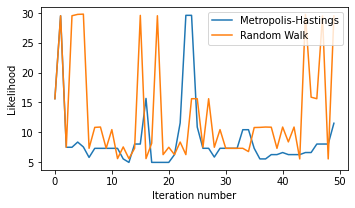

In [15]:
fig = plt.figure(figsize = (5.5, 3))
plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(np.array(r[0]), label = "Metropolis-Hastings")
plt.plot(np.array(rw_l[0]), label = "Random Walk")
plt.legend()

Regular MCMC
8.870186864796464
7.3024796578338504
Squared MCMC
7.9921642198001175
6.754887741082677
Translated MCMC
7.958280953441836
7.297352716555377
Squared Translated MCMC
6.062479254516877
5.522016238167305
Greedy MCMC
5.6495511220337855
5.426152932919197
RW
12.845627122465324
9.407233755330331


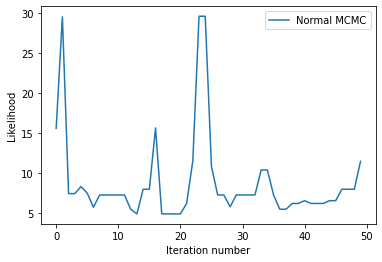

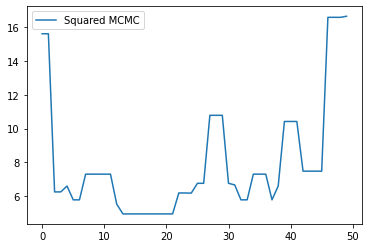

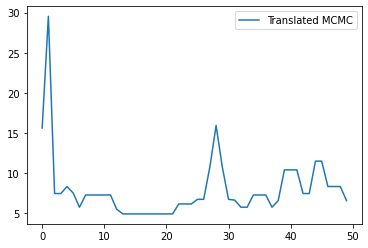

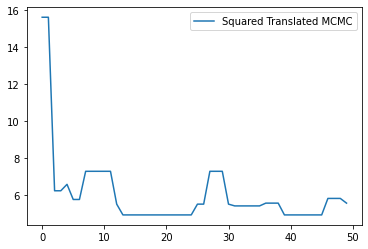

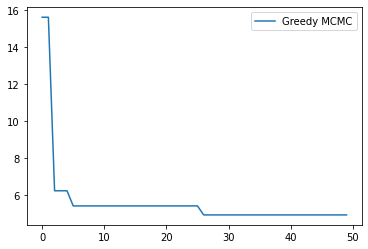

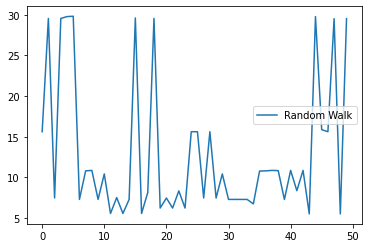

In [17]:
print("Regular MCMC")
print(np.mean(np.array(r[0])))
print(np.median(np.array(r[0])))

print("Squared MCMC")
print(np.mean(np.array(rp[0])))
print(np.median(np.array(rp[0])))

print("Translated MCMC")
print(np.mean(np.array(rt[0])))
print(np.median(np.array(rt[0])))

print("Squared Translated MCMC")
print(np.mean(np.array(rtp[0])))
print(np.median(np.array(rtp[0])))

print("Greedy MCMC")
print(np.mean(np.array(rg[0])))
print(np.median(np.array(rg[0])))

print("RW")
print(np.mean(np.array(rw_l[0])))
print(np.median(np.array(rw_l[0])))

plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(r[0], label = "Normal MCMC")
plt.legend()

plt.show()
plt.plot(rp[0], label = "Squared MCMC")
plt.legend()

plt.show()
plt.plot(rt[0], label = "Translated MCMC")
plt.legend()

plt.show()
plt.plot(rtp[0], label = "Squared Translated MCMC")
plt.legend()

plt.show()
plt.plot(rg[0], label = "Greedy MCMC")
plt.legend()
plt.show()

plt.show()
plt.plot(rw_l[0], label = "Random Walk")
plt.legend()
plt.show()

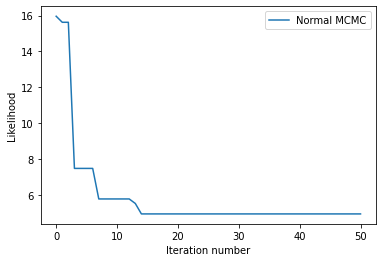

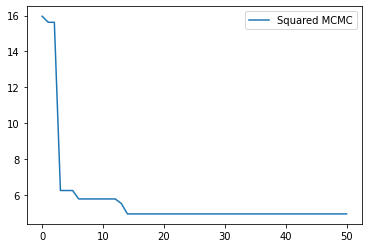

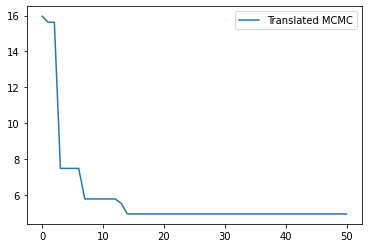

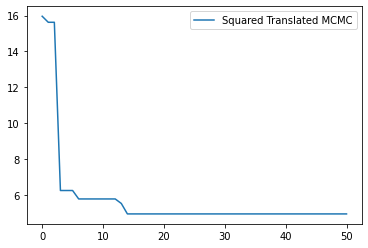

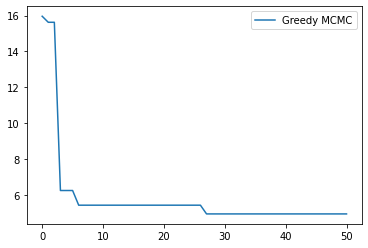

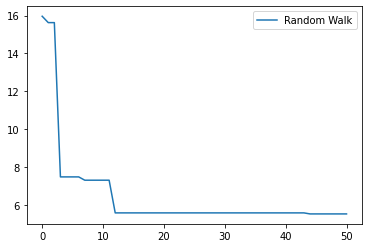

In [18]:
plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(r[1], label = "Normal MCMC")
plt.legend()

plt.show()
plt.plot(rp[1], label = "Squared MCMC")
plt.legend()

plt.show()
plt.plot(rt[1], label = "Translated MCMC")
plt.legend()

plt.show()
plt.plot(rtp[1], label = "Squared Translated MCMC")
plt.legend()

plt.show()
plt.plot(rg[1], label = "Greedy MCMC")
plt.legend()
plt.show()

plt.show()
plt.plot(rw_l[1], label = "Random Walk")
plt.legend()
plt.show()

In [20]:
import itertools

def get_permutations(W):
    """@params: Weighted Adjacency Matrix W as numpy array"""
    # tracks the total number of permutations
    total = 0
    
    # iterate over all permutations of the identity matrix
    for perm in tqdm(itertools.permutations(np.identity(np.shape(W)[0])), total = np.math.factorial(p)):
        # convert to numpy array
        P = np.array(perm)
        
        # check if we have an upper triangular matrix
        if np.allclose(P.T @ W @ P, np.triu(P.T @ W @ P)):
            total += 1
            
    # return the number of suitable permutations
    return total

get_permutations(W_true)

100%|█████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 11910.28it/s]


3

In [21]:
# notears versus MCMC greedy
T, p, s0, graph_type, sem_type = 100, 5, 5, 'ER', 'gauss'
print(f"SEM based on a graph on {p} nodes and {s0} edges, {T} samples.")

B_true = simulate_dag(p, s0, graph_type)
print(f"Original Adjacency Matrix:\n{B_true}.\n")

W_true = simulate_parameter(B_true)
print(f"Original WAM:\n{np.round(W_true, 1)}.\n")

X = simulate_linear_sem(W_true, T, sem_type)
Psi = np.dot(X.T, X)

start = timer()
W_est, h_val = notears_linear(X, lambda1=0.0, loss_type='l2', verbose = False)
print(f"Estimated WAM:\n{np.round(W_est, 1)}.\n")

acc = count_accuracy(B_true, W_est != 0)
print(acc)
print(loss(W_est, X))
total_time = timer() - start
print(f"Elapsed time: {round(total_time, 2)}.")
order = is_dag(B_true)[1]
P_true = np.zeros((p, p))
for i in range(p):
    P_true[order[-i]][i] = 1
    
np.random.seed(seed = 123)
iters = int(100 * total_time)
Prtg, rg = mcmc(iters, False, acc_prob = acc_prob_greed, P = np.identity(p))
W_mcmc = ols_W(X, Prtg)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = count_accuracy(B_true, W_mcmc != 0)
print(acc)

SEM based on a graph on 5 nodes and 5 edges, 100 samples.
Original Adjacency Matrix:
[[0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0.]].

Original WAM:
[[ 0.   0.   0.   0.   0. ]
 [-1.3  0.   0.  -1.9  0. ]
 [ 1.9  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 1.2  0.   0.  -1.2  0. ]].

0123456

 65%|████████████████████████████████████████████████████▏                           | 92/141 [00:00<00:00, 916.78it/s]

7Estimated WAM:
[[ 0.   0.   0.   0.   0. ]
 [-1.7  0.   0.  -1.9  0. ]
 [ 1.7  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 1.2  0.   0.  -1.2  0. ]].

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}
4.6925424620195555
Elapsed time: 1.42.


100%|███████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 912.29it/s]

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}


In [42]:
p, c = 20, 0.25
num_edges = int(c * p * (p - 1) / 2)
print(num_edges)

47


In [43]:
T, p, sparseness_fraction, graph_type, sem_type, iter_total = 1000, 5, 0.25, 'ER', 'gauss', 10

Ps = [5, 10, 30, 50, 75, 100]

results_notears = []
results_mcmc = []
results_omp = []

for p in Ps:
    num_edges = int(sparseness_fraction * p * (p - 1) / 2)
    print(f"p: {p}.\n")

    res_NT = [[] for i in range(6)]
    res_MCMC = [[] for i in range(6)]
    res_omp = [[] for i in range(6)]
    
    for _ in range(iter_total):
        # generate X, Psi
        B_true = simulate_dag(p, num_edges, graph_type)
        W_true = simulate_parameter(B_true)
        X = simulate_linear_sem(W_true, T, sem_type)
        Psi = np.dot(X.T, X)

        # do NO TEARS
        start = timer()
        W_est, h_val = notears_linear(X, lambda1=0.0, loss_type='l2', verbose = False)
        total_time = timer() - start
        
        # get score, save score
        acc = count_accuracy(B_true, W_est != 0)
        res_NT[0].append(acc['tpr'])
        res_NT[1].append(acc['fdr'])
        res_NT[2].append(acc['shd'])
        res_NT[3].append(acc['fpr'])
        res_NT[4].append(loss(W_est, X))
        res_NT[5].append(true_loss(W_est, W_true))    
        
        print(f"Elapsed time {round(total_time, 2)} seconds.")

        # do OMP
        W_omp, r = _K_OMP(X, X, F = [i * (p + 1) for i in range(p)], normalize = True, tol = 1e-8)
        W_omp[np.abs(W_omp) <= 0.3] = 0

        # get score, save score
        acc = count_accuracy(B_true, W_omp != 0)
        res_omp[0].append(acc['tpr'])
        res_omp[1].append(acc['fdr'])
        res_omp[2].append(acc['shd'])
        res_omp[3].append(acc['fpr'])
        res_omp[4].append(loss(W_omp, X))    
        res_omp[5].append(true_loss(W_omp, W_true))    
    
        # get a true permutation matrix
        order = is_dag(B_true)[1]
        P_true = np.zeros((p, p))
        for i in range(p):
            P_true[order[-i]][i] = 1

        # do mcmc
        Prtg, rg = mcmc(int(1e10), False, acc_prob = acc_prob_greed, P = np.identity(p), total_time = total_time)
        W_mcmc = ols_W(X, Prtg)
        W_mcmc[np.abs(W_mcmc) < 0.30] = 0
        
        # get results
        acc = count_accuracy(B_true, W_mcmc != 0)
        res_MCMC[0].append(acc['tpr'])
        res_MCMC[1].append(acc['fdr'])
        res_MCMC[2].append(acc['shd'])
        res_MCMC[3].append(acc['fpr'])
        res_MCMC[4].append(loss(W_mcmc, X))    
        res_MCMC[5].append(true_loss(W_mcmc, W_true))    

    print(res_NT); print(res_MCMC); print(res_omp);

    results_notears.append(res_NT)
    results_mcmc.append(res_MCMC)
    results_omp.append(res_omp)

p: 5.

0123456

  0%|                                                                 | 101/10000000000 [00:00<2777:45:59, 1000.00it/s]

7Elapsed time 1.96 seconds.


  0%|                                                                 | 1903/10000000000 [00:01<2852:35:30, 973.77it/s]


01234567Elapsed time 1.29 seconds.

  0%|                                                                   | 44/10000000000 [00:00<6372:13:59, 435.92it/s]

  0%|                                                                  | 982/10000000000 [00:01<3657:14:17, 759.53it/s]


01234567

  0%|                                                                   | 75/10000000000 [00:00<3777:47:43, 735.29it/s]

Elapsed time 1.06 seconds.


  0%|                                                                  | 939/10000000000 [00:01<3128:42:19, 887.84it/s]


0123456

  0%|                                                                   | 98/10000000000 [00:00<2850:28:50, 974.49it/s]

7Elapsed time 1.21 seconds.


  0%|                                                                 | 1134/10000000000 [00:01<2953:10:04, 940.61it/s]


0123456

  0%|                                                                                  | 0/10000000000 [00:00<?, ?it/s]

7Elapsed time 0.85 seconds.


  0%|                                                                  | 791/10000000000 [00:00<2994:51:53, 927.51it/s]


0123456

  0%|                                                                   | 99/10000000000 [00:00<2830:19:02, 981.44it/s]

7Elapsed time 1.54 seconds.


  0%|                                                                  | 827/10000000000 [00:01<5170:16:42, 537.26it/s]


0123456

  0%|                                                                                  | 0/10000000000 [00:00<?, ?it/s]

7Elapsed time 1.61 seconds.


  0%|                                                                 | 1456/10000000000 [00:01<3061:51:33, 907.22it/s]


01234567

  0%|                                                                 | 103/10000000000 [00:00<2697:03:19, 1029.93it/s]

Elapsed time 2.08 seconds.


  0%|                                                                 | 1911/10000000000 [00:02<3020:42:01, 919.58it/s]


0123456

  0%|                                                                                  | 0/10000000000 [00:00<?, ?it/s]

7Elapsed time 1.43 seconds.


  0%|                                                                 | 1242/10000000000 [00:01<3195:40:01, 869.23it/s]


01234567

  0%|                                                                   | 63/10000000000 [00:00<4453:10:54, 623.77it/s]

Elapsed time 1.69 seconds.


  0%|                                                                 | 1306/10000000000 [00:01<3590:48:36, 773.58it/s]


[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [4.975105146631232, 5.131466201435529, 4.952142447598717, 5.0252659126585115, 4.910484941170506, 4.888654200931207, 5.185667124142803, 4.94709950438461, 5.277519620569526, 4.995176792076789], [5.002256746795536, 5.003862128565589, 5.000011329859088, 5.000690676486443, 5.000110649764382, 5.000377793579926, 5.004787341875838, 5.003446449121342, 5.000967211465719, 5.007478232241741]]
[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [4.9747410716559735, 5.131496127033417, 4.952142752049999, 5.024967340081189, 4.910482189820074, 4.888657383174635, 5.1856674834897305, 4.946958526808419, 5.277520972853726, 4.9953544398605265], [5.001978501277005, 5.004027529752783, 5.00

  0%|                                                                                  | 0/10000000000 [00:00<?, ?it/s]

Elapsed time 5.2 seconds.


  0%|                                                                 | 1976/10000000000 [00:05<7307:01:15, 380.15it/s]


01234567

  0%|                                                                   | 40/10000000000 [00:00<6965:11:00, 398.81it/s]

Elapsed time 6.01 seconds.


  0%|                                                                 | 1959/10000000000 [00:06<8514:50:34, 326.23it/s]


01234567

  0%|                                                                   | 42/10000000000 [00:00<6620:31:50, 419.57it/s]

Elapsed time 7.37 seconds.


  0%|                                                                 | 2858/10000000000 [00:07<7156:09:04, 388.17it/s]


01234567

  0%|                                                                   | 40/10000000000 [00:00<7102:16:27, 391.11it/s]

Elapsed time 8.37 seconds.


  0%|                                                                 | 2590/10000000000 [00:08<8970:33:37, 309.65it/s]


01234567

  0%|                                                                   | 36/10000000000 [00:00<7828:16:44, 354.84it/s]

Elapsed time 5.74 seconds.


  0%|                                                                 | 1919/10000000000 [00:05<8297:47:43, 334.76it/s]


012345678

  0%|                                                                   | 36/10000000000 [00:00<7765:00:48, 357.73it/s]

Elapsed time 7.05 seconds.


  0%|                                                                 | 2787/10000000000 [00:07<7021:49:20, 395.59it/s]


01234567

  0%|                                                                   | 43/10000000000 [00:00<6460:04:50, 429.99it/s]

Elapsed time 6.07 seconds.


  0%|                                                                 | 2455/10000000000 [00:06<6869:17:36, 404.38it/s]


01234567

  0%|                                                                   | 41/10000000000 [00:00<6950:57:05, 399.63it/s]

Elapsed time 5.16 seconds.


  0%|                                                                 | 2084/10000000000 [00:05<6876:18:44, 403.96it/s]


01234567

  0%|                                                                   | 45/10000000000 [00:00<6201:16:01, 447.94it/s]

Elapsed time 4.99 seconds.


  0%|                                                                 | 2044/10000000000 [00:04<6781:22:58, 409.62it/s]


01234567

  0%|                                                                   | 45/10000000000 [00:00<6206:47:10, 447.54it/s]

Elapsed time 4.89 seconds.


  0%|                                                                 | 1987/10000000000 [00:04<6839:15:59, 406.15it/s]


[[1.0, 0.9090909090909091, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091], [0.0, 0.09090909090909091, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09090909090909091], [0, 1, 2, 0, 0, 0, 0, 0, 0, 1], [0.0, 0.029411764705882353, 0.058823529411764705, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029411764705882353], [10.129240249684129, 10.363024082351034, 10.219250071350173, 10.141631052810625, 10.103179934972959, 10.024760016111456, 9.958431585459701, 9.985508084332865, 9.949564582002374, 9.928349888656326], [10.024461065074693, 10.258132241581434, 10.17921693683715, 10.044711510744438, 10.01510623063262, 10.07873314116839, 10.006104655558863, 10.011954996718286, 10.012661570765614, 10.082081333407661]]
[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [10.136329158255936, 10.283735254294708, 10.10985047330302, 10.140305554802545, 1

  0%|                                                                | 36308/10000000000 [09:36<44131:11:06, 62.94it/s]


012345678Elapsed time 902.93 seconds.


  0%|                                                                | 55867/10000000000 [15:02<44894:40:49, 61.87it/s]


01234567Elapsed time 403.75 seconds.


  0%|                                                                | 26376/10000000000 [06:43<42520:46:11, 65.33it/s]


0123456789Elapsed time 642.22 seconds.


  0%|                                                                | 35068/10000000000 [10:42<50869:32:53, 54.61it/s]


012345678Elapsed time 293.81 seconds.


  0%|                                                                | 20848/10000000000 [04:53<39147:03:35, 70.96it/s]


012345678Elapsed time 254.52 seconds.


  0%|                                                                | 14304/10000000000 [04:14<49427:49:51, 56.20it/s]


012345678Elapsed time 824.61 seconds.


  0%|                                                                | 53989/10000000000 [13:44<42426:14:49, 65.47it/s]


012345678910Elapsed time 1039.06 seconds.


  0%|                                                                | 65635/10000000000 [17:19<43974:27:21, 63.17it/s]


01234567Elapsed time 387.73 seconds.


  0%|                                                                | 21025/10000000000 [06:27<51226:13:43, 54.23it/s]


0123456789Elapsed time 1425.83 seconds.


  0%|                                                                | 66993/10000000000 [23:45<59120:29:58, 46.98it/s]


[[0.9537037037037037, 0.9537037037037037, 0.9722222222222222, 0.9537037037037037, 0.9907407407407407, 0.9814814814814815, 0.8611111111111112, 0.8611111111111112, 0.9537037037037037, 0.9537037037037037], [0.11965811965811966, 0.13445378151260504, 0.045454545454545456, 0.14166666666666666, 0.02727272727272727, 0.027522935779816515, 0.19130434782608696, 0.211864406779661, 0.11206896551724138, 0.30405405405405406], [16, 20, 6, 21, 3, 4, 34, 37, 15, 46], [0.04281345565749235, 0.04892966360856269, 0.01529051987767584, 0.05198776758409786, 0.009174311926605505, 0.009174311926605505, 0.0672782874617737, 0.0764525993883792, 0.039755351681957186, 0.13761467889908258], [56.04248751842643, 206.58950156532345, 74.50789283021172, 185.9366887120819, 41.35043695663018, 34.20663134044741, 259.84959177165103, 2229.976318068225, 70.62714526022305, 727.5956022602635], [55.72195594176055, 219.46924053326873, 76.2968790311863, 192.712115447634, 41.71853052432685, 34.15427761267721, 250.87439252395805, 2150.

  0%|                                                               | 80105/10000000000 [53:12<110721:02:58, 25.09it/s]


012345678910Elapsed time 1850.52 seconds.


  0%|                                                                | 58157/10000000000 [30:50<88386:46:05, 31.43it/s]


0123456789Elapsed time 1443.83 seconds.


  0%|                                                                | 47014/10000000000 [24:03<85306:04:05, 32.56it/s]


0123456789Elapsed time 1463.92 seconds.


  0%|                                                                | 47896/10000000000 [24:23<84900:28:11, 32.72it/s]


012345678910Elapsed time 1796.64 seconds.


  0%|                                                                | 58245/10000000000 [29:56<85683:11:57, 32.42it/s]


012345678Elapsed time 1796.36 seconds.


  0%|                                                                | 58504/10000000000 [29:56<85290:35:11, 32.57it/s]


0123456789Elapsed time 2137.7 seconds.


  0%|                                                                | 69664/10000000000 [35:37<85238:00:17, 32.59it/s]


012345678910Elapsed time 1536.88 seconds.


  0%|                                                                | 50027/10000000000 [25:36<85335:30:35, 32.55it/s]


01234567891011Elapsed time 2101.51 seconds.


  0%|                                                                | 68153/10000000000 [35:01<85652:16:44, 32.43it/s]


012345678910Elapsed time 2894.01 seconds.


  0%|                                                                | 86155/10000000000 [48:13<93298:44:00, 29.77it/s]


[[0.8790849673202614, 0.7777777777777778, 0.6143790849673203, 0.7516339869281046, 0.8235294117647058, 0.9575163398692811, 0.8660130718954249, 0.4738562091503268, 0.8986928104575164, 0.8169934640522876], [0.3886363636363636, 0.4503464203233256, 0.46742209631728043, 0.4911504424778761, 0.4337078651685393, 0.24289405684754523, 0.4018058690744921, 0.5632530120481928, 0.3389423076923077, 0.48559670781893005], [198, 254, 280, 292, 238, 102, 216, 346, 162, 288], [0.18607181719260066, 0.21218715995647444, 0.1795429815016322, 0.24156692056583243, 0.2100108813928183, 0.10228509249183895, 0.19368879216539717, 0.20348204570184983, 0.15342763873775844, 0.25680087051142547], [176881.1770642038, 238033.1837712563, 4841043.149314436, 1166738.7376142787, 433814.4641678651, 9053.838296451484, 95282.61200473286, 21972267.957465746, 107884.776852113, 46546.6970963579], [182604.33724825468, 240980.3657324048, 4742931.127575701, 1144514.9632905899, 436298.90982390865, 9225.224220335504, 93647.66916848683, 2

  0%|                                                             | 85692/10000000000 [3:26:05<400833:02:54,  6.93it/s]


KeyboardInterrupt: 

In [44]:
from scipy.stats import sem

NT_means = [[] for i in range(6)]
NT_sems = [[] for i in range(6)]
for elem in results_notears:
    for i in range(6):
        NT_means[i].append(np.mean(elem[i]))
        NT_sems[i].append(sem(elem[i]))
        
MCMC_means = [[] for i in range(6)]
MCMC_sems = [[] for i in range(6)]
for elem in results_mcmc:
    for i in range(6):
        MCMC_means[i].append(np.mean(elem[i]))
        MCMC_sems[i].append(sem(elem[i]))

OMP_means = [[] for i in range(6)]
OMP_sems = [[] for i in range(6)]
for elem in results_omp:
    for i in range(6):
        OMP_means[i].append(np.mean(elem[i]))
        OMP_sems[i].append(sem(elem[i]))

In [49]:
print(NT_means); print(NT_sems); print(MCMC_means); print(MCMC_sems); print(OMP_means); print(OMP_sems);

[[1.0, 0.9727272727272727, 0.9435185185185186, 0.7859477124183006], [0.0, 0.03484848484848485, 0.13153205505215243, 0.4263755141404853], [0.0, 0.4, 20.2, 237.6], [0.0, 0.011764705882352941, 0.04984709480122324, 0.19390642002176278], [5.028858189159943, 10.080293954773165, 388.66822962834834, 2908754.659364744], [5.002398855975561, 10.071316368248914, 375.6939391041866, 2778658.922569941]]
[[0.0, 0.013886593015017702, 0.014374235829870385, 0.045666613606169464], [0.0, 0.018904007345669598, 0.02779251395421283, 0.028301845616712826], [0.0, 0.22110831935702666, 4.647101844758252, 22.47329279141997], [0.0, 0.00650318586344196, 0.012190294451372935, 0.013829599123444293], [0.04044555407232891, 0.043846051337669036, 214.80982880141497, 2168635.282002668], [0.0007799721237076547, 0.026665237221076016, 206.11073693805346, 2051072.4721214075]]
[[1.0, 1.0, 0.999074074074074, 0.9996732026143791], [0.0, 0.0, 0.005471226021684737, 0.026062138862841887], [0.0, 0.0, 0.7, 8.3], [0.0, 0.0, 0.0018348623

0 0
1 0
2 0
0 1
1 1
2 1


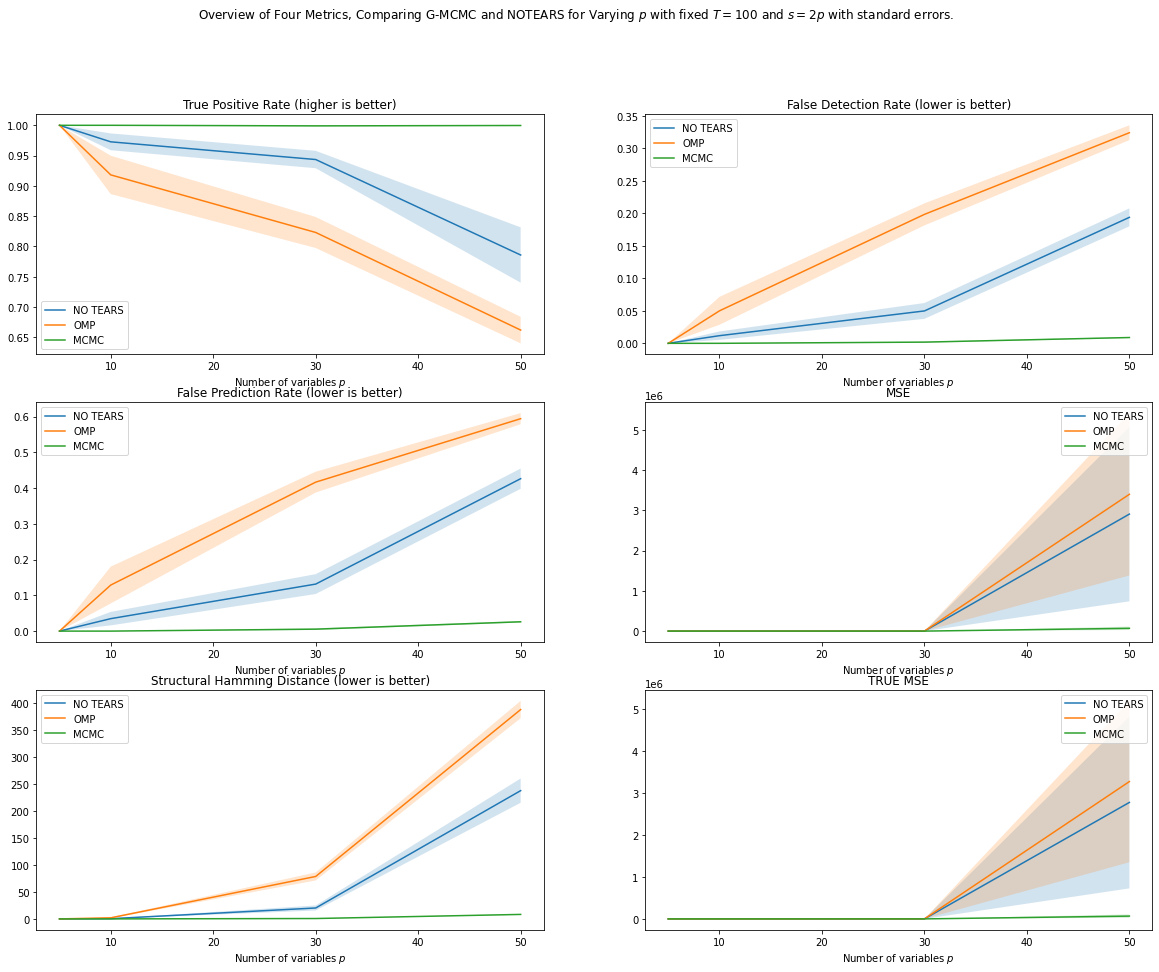

In [48]:
fig, axs = plt.subplots(3, 2, figsize = (20, 15))
fig.suptitle("Overview of Four Metrics, Comparing G-MCMC and NOTEARS for Varying $p$ with fixed $T = 100$ and $s = 2p$ with standard errors.")
titles = ['True Positive Rate (higher is better)', 'False Prediction Rate (lower is better)', 'Structural Hamming Distance (lower is better)', 'False Detection Rate (lower is better)', 'MSE', 'TRUE MSE']
Ps = [5, 10, 30, 50]

for i in range(6):
    print(i % 3, i // 3)
    axs[i % 3, i // 3].plot(Ps, np.array(NT_means)[i, :], label = "NO TEARS")
    axs[i % 3, i // 3].fill_between(Ps, np.array(NT_means)[i, :] - np.array(NT_sems)[i, :], np.array(NT_means)[i, :] + np.array(NT_sems)[i, :], alpha = 0.2)

    axs[i % 3, i // 3].plot(Ps, np.array(OMP_means)[i, :], label = "OMP")
    axs[i % 3, i // 3].fill_between(Ps, np.array(OMP_means)[i, :] - np.array(OMP_sems)[i, :], np.array(OMP_means)[i, :] + np.array(OMP_sems)[i, :], alpha = 0.2)

    axs[i % 3, i // 3].plot(Ps, np.array(MCMC_means)[i, :], label = "MCMC")
    axs[i % 3, i // 3].fill_between(Ps, np.array(MCMC_means)[i, :] - np.array(MCMC_sems)[i, :], np.array(MCMC_means)[i, :] + np.array(MCMC_sems)[i, :], alpha = 0.2)    
    axs[i % 3, i // 3].set_title(titles[i])
    
    axs[i % 3, i // 3].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='')

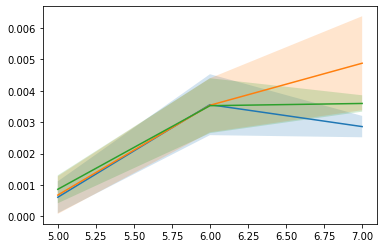

In [38]:
i = -1
plt.plot(Ps, np.array(NT_means)[i, :] - Ps, label = "NO TEARS")
plt.fill_between(Ps, np.array(NT_means)[i, :] - Ps - np.array(NT_sems)[i, :], np.array(NT_means)[i, :] - Ps + np.array(NT_sems)[i, :], alpha = 0.2)
plt.plot(Ps, np.array(OMP_means)[i, :] - Ps, label = "OMP")
plt.fill_between(Ps, np.array(OMP_means)[i, :] - Ps - np.array(OMP_sems)[i, :], np.array(OMP_means)[i, :] - Ps + np.array(OMP_sems)[i, :], alpha = 0.2)
plt.plot(Ps, np.array(MCMC_means)[i, :] - Ps, label = "MCMC")
plt.fill_between(Ps, np.array(MCMC_means)[i, :] - Ps - np.array(MCMC_sems)[i, :], np.array(MCMC_means)[i, :] - Ps + np.array(MCMC_sems)[i, :], alpha = 0.2)    